In [1]:
%%html
<style>
table {float:left}
</style>

## Tf-Idf & Multinomial NB

- tokenizing/POS tagging $\rightarrow$ tf-idf vectorization
- Model: Multinomial Naive Bayes
- Data: 165,810 reviews

### Modeling

- Without Oversampling
- With Oversampling

### Results

|                      | Accuracy | Recall | F1-Score |
|----------------------|:--------:|:------:|:--------:|
| Without Oversampling |   0.77   |  0.78  |   0.77   |
| With Oversampling    |   0.85   |  0.86  |   0.85   |

- Before oversampling, recall of 역겹다/슬프다/무섭다 is lower than precision.
- After oversampleing, recall of those labels is improved.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import Counter

from file_io import *
from words_preprocessing import *

In [3]:
train_joy = read_data('../train_data_labeled_joy.txt')
train_anger = read_data('../train_data_labeled_anger.txt')
train_disgust = read_data('../train_data_labeled_disgust.txt')
train_sadness = read_data('../train_data_labeled_sadness.txt')
train_fear = read_data('../train_data_labeled_fear.txt')

trains = [train_joy, train_anger, train_disgust, train_sadness, train_fear]
labels = ['기쁘다', '화나다', '역겹다', '슬프다', '무섭다']

num_dic = {}
for label, data in zip(labels, trains):
    num_dic[label] = len(data)
label_count = Counter(num_dic)
sum_ = sum(label_count.values())
print("Number of Data: ", sum_)
print(label_count)
print()

for label in label_count.keys():
    print(label ,": {}%".format(round(label_count[label] / sum_, 2)))

Number of Data:  165810
Counter({'기쁘다': 73614, '화나다': 40501, '슬프다': 20701, '역겹다': 20390, '무섭다': 10604})

기쁘다 : 0.44%
화나다 : 0.24%
역겹다 : 0.12%
슬프다 : 0.12%
무섭다 : 0.06%


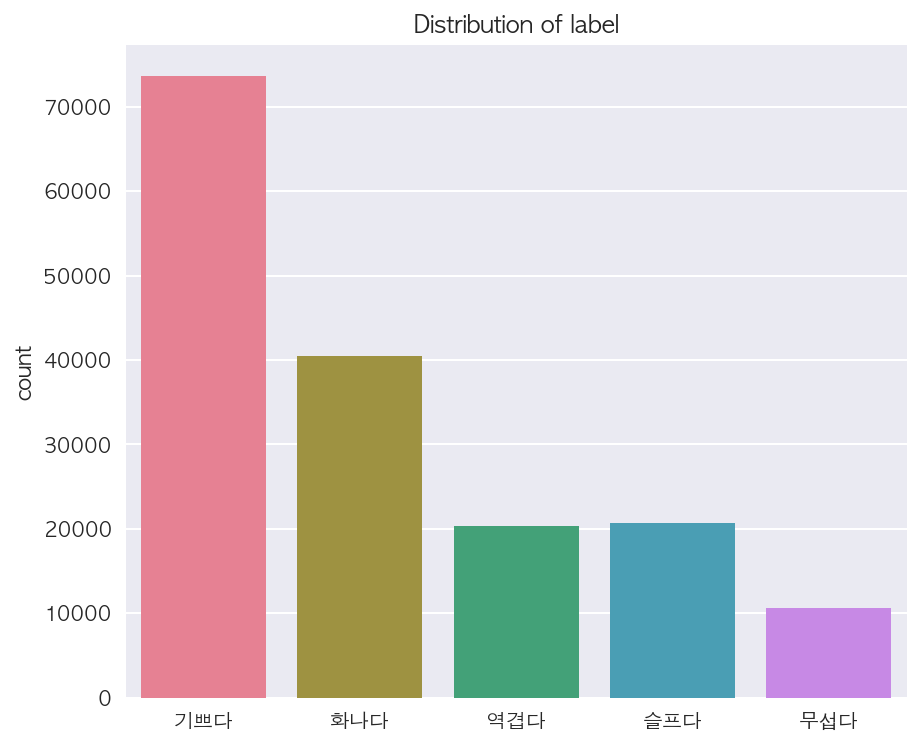

In [4]:
df = pd.DataFrame(list(label_count.values()), 
                  index=list(label_count.keys()), 
                  columns=['count'])

plt.figure(figsize=(7, 6))
plt.title("Distribution of label")
sns.barplot(x=df.index, y=df['count'], data=df, palette='husl');

- Imbalanced distribution of labels.
    1. Number of reviews of horror movies are small.
    2. Most of positive emotions are labeled as 기쁘다.

In [5]:
train_joy_labeled = [(row, 0) for row in train_joy]
train_anger_labeled = [(row, 1) for row in train_anger]
train_disgust_labeled = [(row, 2) for row in train_disgust]
train_sadness_labeled = [(row, 3) for row in train_sadness]
train_fear_labeled = [(row, 4) for row in train_fear]

train_lst = [train_joy_labeled, train_anger_labeled, 
             train_disgust_labeled, train_sadness_labeled, train_fear_labeled]

In [6]:
train = []
for data in train_lst:
    train += data

print(len(train))

165810


In [7]:
train[100]

(["'본격사심방송' 보다가 발견한 영화. 기대안했는데 유쾌한 유치함이 기분좋게 해주는 영화인듯. 추천합니다"], 0)

In [8]:
%%time
train_docs = [(tokenize(row[0][0]), row[1]) for row in train]

CPU times: user 3min 1s, sys: 878 ms, total: 3min 2s
Wall time: 2min 50s


In [9]:
save_pickle('../train_labeled_0505.pickle', train)
save_pickle('../train_docs_0505.pickle', train_docs)

In [10]:
y0 = [row[1] for row in train_docs]
x0 = [' '.join(row[0]) for row in train_docs]

X_train, X_test, y_train, y_test = train_test_split(x0, y0, 
                                                    random_state=1234)

len(X_train), len(X_test), len(y_train), len(y_test)

(124357, 41453, 124357, 41453)

In [11]:
clf = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model = clf.fit(X_train, y_train)
model

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [12]:
%%time
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross validation score: {}".format(scores))

Cross validation score: [ 0.7776795   0.77034416  0.77600418  0.77575392  0.76867712]
CPU times: user 52.4 s, sys: 1.81 s, total: 54.2 s
Wall time: 54.2 s


In [13]:
y_pred = model.predict(X_test)

In [14]:
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

[[16247   984   280   768   177]
 [ 1238  7903   553   230   171]
 [  579   966  3319   145    49]
 [ 1334   502   116  3178    91]
 [  474   425   100   138  1486]]


In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.88      0.85     18456
          1       0.73      0.78      0.76     10095
          2       0.76      0.66      0.70      5058
          3       0.71      0.61      0.66      5221
          4       0.75      0.57      0.65      2623

avg / total       0.77      0.78      0.77     41453



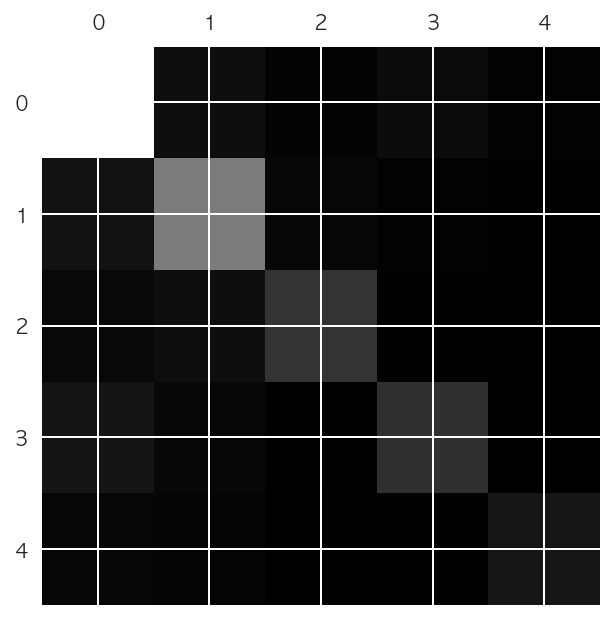

In [16]:
plt.figure(figsize=(5, 5))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

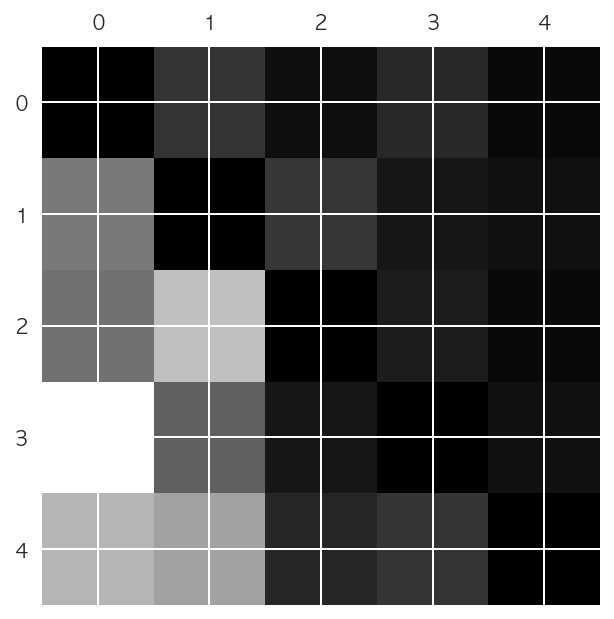

In [17]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(5, 5))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

- Confusion Matrix 시각화 분석
    - '기쁘다'를 제외한 나머지 감정에서 잘못 분류된 대부분의 경우가 '기쁘다'로 분류된 경우
    - 특히 '역겹다'의 경우 그 비율이 큼

In [18]:
test_sadness = []
for sentence, tag in zip(X_test, y_test):
    if tag == 3:
        test_sadness.append(sentence)
        
test_joy_predict = []
for sentence, tag in zip(X_test, y_pred):
    if tag == 0:
        test_joy_predict.append(sentence)
        
predict_sad_joy = list(set(test_joy_predict).intersection(set(test_sadness)))

In [19]:
for _, sent in enumerate(predict_sad_joy[:100:10]):
    pprint(sent)

('기억/Noun 저편/Noun 끝/Noun 자락/Noun 에/Josa 남다/Verb 여운/Noun 의/Josa ../Punctuation '
 '평온/Noun 한/Josa 여백/Noun 이/Josa 있다/Adjective 영화/Noun 들/Suffix 은/Josa '
 '1990/Number 년/Noun ~/Punctuation 2000/Number 년대/Noun 영화/Noun 가/Josa 최고/Noun '
 '가/Josa 아니다/Adjective 싶다/Verb ../Punctuation 시대/Noun 가/Josa 변하다/Adjective '
 '인가/Josa ../Punctuation 사람/Noun 이/Josa 변하다/Adjective 인가/Josa ../Punctuation '
 '이제/Noun 그렇다/Adjective 영화/Noun 들/Suffix 을/Josa 찾기/Noun 가/Josa 쉬다/Verb 않다/Verb '
 '../Punctuation')
('분명/Noun 15/Number 세/Noun 관람/Noun 가/Josa 라고/Josa 되어다/Verb 가슴/Noun 이/Josa '
 '노출/Noun 되다/Verb 배드/Noun 신/Noun 이/Josa 있다/Adjective 베리/Noun 굿/Noun 인데/Josa '
 '♡♡♡/Foreign')
('"""/Punctuation 대박/Noun !/Punctuation 내/Noun 생/Noun 에/Josa 이렇다/Adjective '
 '드라마/Noun 는/Josa 없다/Adjective ./Punctuation 교훈/Noun ,/Punctuation 풍자/Noun '
 '다/Adverb 있다/Adjective ./Punctuation 다시/Noun 보다/Verb ㅠ/KoreanParticle '
 '지상파/Noun 에서/Josa 방송/Noun 하다/Verb 완전/Noun 인기/Noun 짱/Suffix 이다/Verb 아쉬움/Noun '
 './Punctuation 더/Noun 오래/Noun 하다/Ver

#### '기쁘다'로 잘못 분류된 '슬프다' 리뷰 첫 100개 중 10개 단위로 확인

- [Noise] 오랜만에 맘에 드는 애니네요 제발 업 좀 빨리 해주세요 ㅜㅜ
- [Multi] 김지영감독님 수고 많으셨습니다.마지막 로이킴 봄봄봄 노래가 이렇게 슬픈줄..잘 보았습니다. 꼭 보세요 강추
- [Noise] 마미를 보고 봐서 조금 아쉬웠지만 데뷔작이라고 하기엔 정말 좋았다. 자비에돌란의 감성은 놀랍다.
- [Noise] 극장에서 보이 못한게 아쉽네요. 좋은영화입니다.
- [Noise] 아..다시보고싶네요ㅜㅜ리메이크안되나요?제인생최고의드라마!그대와함께!
- [False Negative] ㅠㅠ 진실은 밝혀져야합니다
- [Noise] 마음을 찡하게 하는 장군이와 천둥이와의 아름다운 우정이...임수정씨의 열연과 함께 감동적인 작품입니다~인간성이 상실되어 가는 지금 마음 따뜻해지게 하는 그런 작품인 것 같네요^^
- [Noise] 드라마를 이렇게까지 집중해서 본건 처음인것 같습니다 연출력도 연출력이지만 배우들 연기와 스토리가 너무 좋았습니다ㅠㅠ 본방으로 못본게 너무 아쉬울정도!
- [Noise] 개봉하자마자 본 보람이 있네여ㅠㅠㅠ 꾸르잼!
- [Noise] 으웩우우에에에에ㅜ우우웅

### Oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler
rnd_os = RandomOverSampler(random_state=1234)

x = np.array(x0).reshape(-1, 1)
X, y = rnd_os.fit_sample(x, y0)
X = [x[0] for x in X.tolist()]

len(X), len(y)

(368070, 368070)

In [21]:
Counter(y)

Counter({0: 73614, 1: 73614, 2: 73614, 3: 73614, 4: 73614})

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                        random_state=1234)

len(X_train2), len(X_test2), len(y_train2), len(y_test2)

(276052, 92018, 276052, 92018)

In [23]:
clf2 = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model2 = clf2.fit(X_train2, y_train2)
model2

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [24]:
%%time
scores2 = cross_val_score(clf2, X_train2, y_train2, cv=5)
print("Cross validation score: {}".format(scores2))

Cross validation score: [ 0.84307759  0.84455996  0.84396225  0.84075349  0.84225112]
CPU times: user 1min 52s, sys: 3.63 s, total: 1min 56s
Wall time: 1min 56s


In [25]:
y_pred2 = model2.predict(X_test2)

In [26]:
print(confusion_matrix(y_test2, y_pred2))

[[14164  1179   699  1822   546]
 [ 1244 14801  1220   615   499]
 [  585  1009 16226   327   163]
 [ 1041   718   349 16057   286]
 [  290   332   176   210 17460]]


In [27]:
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

          0       0.82      0.77      0.79     18410
          1       0.82      0.81      0.81     18379
          2       0.87      0.89      0.88     18310
          3       0.84      0.87      0.86     18451
          4       0.92      0.95      0.93     18468

avg / total       0.85      0.86      0.85     92018



- 오버샘플링 이후 recall 상승
- precision/recall 크게 상승 (특히 역겹다/슬프다/무섭다)

In [28]:
save_pickle('../model/mnb_0505.pickle', model)
save_pickle('../model/mnb_0505_ov.pickle', model2)